## What questions are we solving here? 
- [ ] Number of Contributors dropping off
- [ ] Helping with new contributors
- [ ] Whose helping most
- [ ] Ratio of helpers to askers
- [ ] Chat responsive
- [ ] Do people have more questions at same time
- [ ] Contributor happiness


In [2]:
# Importing Libraries
import time
import nltk
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
stops = set(stopwords.words("english"))
chat = pd.read_json('../data/oppia_chat.json')
def cleanData(text, lowercase = False, remove_stops = False, stemming = False):
    txt = text
    txt = re.sub(r'[^A-Za-z0-9\s]',r'',txt)
    txt = re.sub(r'\n',r' ',txt)
    
    if lowercase:
        txt = " ".join([w.lower() for w in txt.split()])
        
    if remove_stops:
        txt = " ".join([w for w in txt.split() if w not in stops])
    
    if stemming:
        st = PorterStemmer()
        txt = " ".join([st.stem(w) for w in txt.split()])

    return txt

def Extract_Username(column):
    temp_dict = dict(column)
    return temp_dict['username']

def Extract_Issue_Number(column):
    if column != []:
        temp_dict = dict(column[0])
        return temp_dict['number']
    else:
        return np.nan 
    
def Extract_URLs(column):
    if column != []:
        temp_dict = dict(column[0])
        return temp_dict[u'url']
    else:
        return np.nan
    
def Mentions(column):
    mention_lst = ', '.join(re.findall("@([a-z0-9_]+)", column, re.I))
    return mention_lst
chat['username'] = chat['fromUser'].apply(Extract_Username)
chat['issue number'] = chat['issues'].apply(Extract_Issue_Number)
chat['url'] = chat['urls'].apply(Extract_URLs)
chat['mentions'] = chat['text'].apply(Mentions)
chat['mentions'].replace(to_replace ='', value= np.nan, inplace = True )
chat['sent'] = pd.to_datetime(chat['sent'])
chat['editedAt'] = pd.to_datetime(chat['editedAt'])
chat['question_marks'] = chat['text'].apply(lambda comment: comment.count('?'))
chat['Year'] = chat['sent'].dt.year
chat['Month'] = chat['sent'].dt.month
chat['Quarter'] = chat['sent'].dt.quarter
chat['DOW'] = chat['sent'].dt.dayofweek
chat['Day'] = chat['sent'].dt.day
chat['Hour'] = chat['sent'].dt.hour
chat['Date'] = chat['sent'].dt.date

cols_to_drop = ["fromUser","html","issues","meta","status","unread","urls"]
chat.drop(cols_to_drop, axis=1, inplace=True)
chat['text'] = chat['text'].apply(cleanData, lowercase = True, remove_stops = True, stemming = True)

In [3]:
chat2017 = chat[chat['Year'] == 2017]
chat2018 = chat[chat['Year'] == 2018]

In [4]:
UNIQUE_USERS_2017 = chat2017.username.unique()
UNIQUE_USERS_2018 = chat2018.username.unique()

In [5]:
print ("Numer of Unique Users in 2017: {}".format(len(UNIQUE_USERS_2017)))
print ("Numer of Unique Users in 2018: {}".format(len(UNIQUE_USERS_2018)))

Numer of Unique Users in 2017: 173
Numer of Unique Users in 2018: 58


### Number of Unique Users in 2017 and 2018

209 users showed up in the Gitter chat during 2017 and only 58 of them are active as of Jan 1st 2018

In [6]:
from tqdm import tqdm
fromchat2017 = chat[chat['Year'] >= 2017]
ACTIVE_USERS_2017 = list(fromchat2017.username.unique())
LAST_SEEN_USER = {}
FIRST_SEEN_USER = {}
for user in tqdm(ACTIVE_USERS_2017):
    LAST_SEEN_USER[user] = fromchat2017[fromchat2017['username']== user].Date.max()
    FIRST_SEEN_USER[user] = fromchat2017[fromchat2017['username']== user].Date.min() 

100%|██████████| 209/209 [00:01<00:00, 205.16it/s]


In [7]:
len(ACTIVE_USERS_2017)

209

In [8]:
DAYS_SINCE  = {}
for user in tqdm(LAST_SEEN_USER):
    DAYS_SINCE[user] = (fromchat2017.Date.max() - LAST_SEEN_USER[user]).days

100%|██████████| 209/209 [00:00<00:00, 868.86it/s]


In [9]:
DAYS_SINCE = pd.DataFrame(list(DAYS_SINCE.items()), columns=['user', 'Absent']).sort_values(by='Absent', ascending=False)

In [10]:
DAYS_SINCE.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Absent,209.0,201.325359,143.086275,0.0,54.0,218.0,353.0,424.0


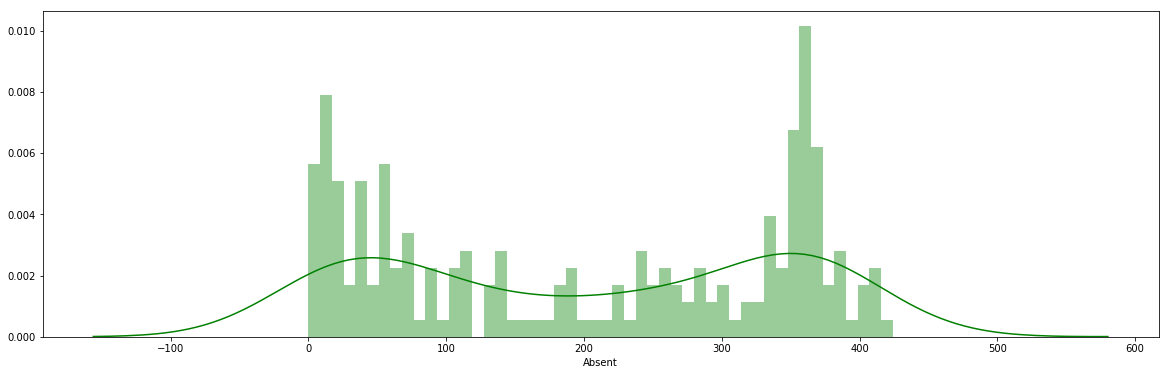

In [11]:
plt.figure(figsize=(20,6))
sns.distplot(DAYS_SINCE.Absent, bins=50, color='g')

In [12]:
DAYS_SINCE[DAYS_SINCE.Absent >218.0	].shape
INACTIVE = DAYS_SINCE[DAYS_SINCE.Absent> 218.0].user

In [13]:
NO_USERS_DROPPED_OFF = len(ACTIVE_USERS_2017) - len(INACTIVE)
print (NO_USERS_DROPPED_OFF, "dropped out of", len(ACTIVE_USERS_2017) , "users")
print ("{:.2f}".format(NO_USERS_DROPPED_OFF/len(ACTIVE_USERS_2017)  * 100), "% users are inactive")

105 dropped out of 209 users
50.24 % users are inactive


## Helping with new contributors
- [ ] Whose helping most
- [ ] Ratio of helpers to askers
- [ ] Chat responsive

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist
from tqdm import tqdm
tfidfvec = TfidfVectorizer(analyzer='word', ngram_range = (1,4), min_df=5)
tfidfdata = tfidfvec.fit_transform(fromchat2017['text'])
feature_names = tfidfvec.get_feature_names()
print ("Number of Features:", len(feature_names))
# create dataframe for features
tfidf_df = pd.DataFrame(tfidfdata.todense())
tfidf_df.columns = feature_names
X = tfidf_df
kmeans = KMeans(n_clusters=2)
kmeans.fit(X=tfidf_df)
cluster = pd.DataFrame(fromchat2017[['text','mentions','username','question_marks']])
cluster['cluster'] = kmeans.predict(tfidf_df)
cluster['text']  = fromchat2017['text']

Number of Features: 2133


In [15]:
HELPLIST1 = cluster['mentions'].value_counts()
HELPLIST2 = cluster.username.value_counts()

In [16]:
HELPLIST1.head(15)

seanlip             281
shaz13              104
ashish3805           71
1995YogeshSharma     67
pranavsid98          53
himanshu             50
andromfins           44
DubeySandeep         43
Arunabh98            41
WickedBrat           37
shubha1593           36
wxyxinyu             24
saeedjassani         20
anmolshkl            19
mdew192837           19
Name: mentions, dtype: int64

In [17]:
HELPLIST2.head(15)

seanlip             1216
shaz13               729
Arunabh98            374
jaredsilver          322
ashish3805           297
1995YogeshSharma     271
pranavsid98          233
wxyxinyu             200
saeedjassani         140
himanshu-dixit       138
WickedBrat           138
andromfins           124
yashLadha            112
mdew192837           103
kevinlee12            94
Name: username, dtype: int64

In [18]:
HELP_USER_1 = list(pd.DataFrame(HELPLIST1).reset_index()['index'].head(30))
HELP_USER_2 = list(pd.DataFrame(HELPLIST2).reset_index()['index'].head(30))
INTERSECT_LIST = list(set(HELP_USER_1).intersection(HELP_USER_2))

### Helping out the most

In [19]:
print (INTERSECT_LIST)

['WickedBrat', 'anookeen', 'wxyxinyu', 'mdew192837', 'Nix07', 'shubha1593', 'DubeySandeep', 'ashish3805', 'darthgera123', 'YimingPan', 'SudhanvaMG', 'kevinlee12', 'saeedjassani', 'pranavsid98', 'cosmicAsymmetry', 'jaredsilver', 'andromfins', 'shaz13', '1995YogeshSharma', 'Arunabh98', 'rachelwchen', 'seanlip']


In [20]:
cluster['question_marks_bin'].value_counts()

KeyError: 'question_marks_bin'

## Ratio of Asking to Answering Questions

In [21]:
cluster['question_marks_bin'].value_counts()[1]/cluster['question_marks_bin'].value_counts()[0] * 100

KeyError: 'question_marks_bin'

In [ ]:
fromchat2017.head()

Text(0,0.5,'Count')

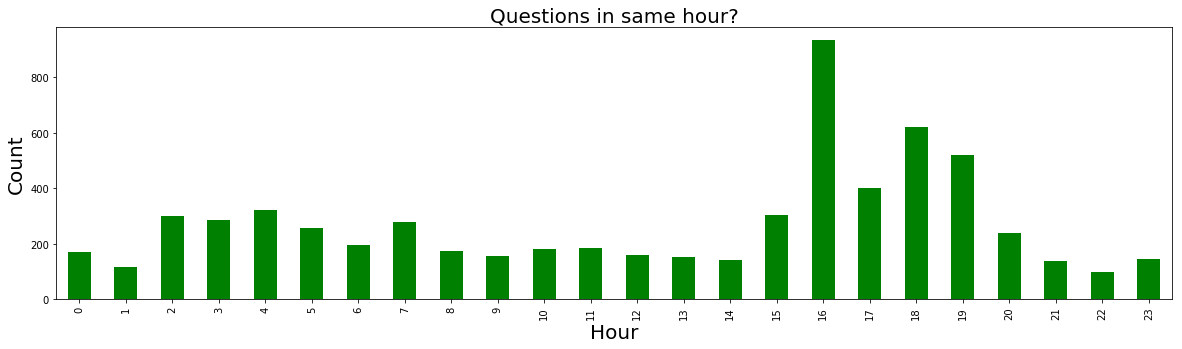

In [22]:
plt.title('Questions in same hour?', fontsize=20)
fromchat2017.groupby(by='Hour').count()['question_marks'].plot(figsize=(20,5), kind='bar', color='green')
plt.xlabel('Hour', fontsize=20)
plt.ylabel('Count', fontsize=20)

In [24]:
fromchat2017.head()

,editedAt,id,mentions,readBy,sent,text,v,username,issue number,url,question_marks,Year,Month,Quarter,DOW,Day,Hour,Date
0,NaT,5a81f100ce68c3bc7479a82e,NaN,40,2018-02-12 19:54:40.690,congratul commun oppia accept gsoc 2018 sparkl,1,jervis446,NaN,NaN,0,2018,2,1,0,12,19,2018-02-12
1,NaT,5a81f123b3c4a0d376141863,all,40,2018-02-12 19:55:15.764,congrat,1,WickedBrat,NaN,NaN,0,2018,2,1,0,12,19,2018-02-12
2,NaT,5a820f667084124a346bdfeb,NaN,37,2018-02-12 22:04:22.773,hey gsoc idea oppia,1,darthgera123,NaN,NaN,1,2018,2,1,0,12,22,2018-02-12
3,NaT,5a820fa693be87284dabafb8,darthgera123,37,2018-02-12 22:05:26.766,darthgera123 follow linkhttpsgithubcomoppiaopp...,1,WickedBrat,NaN,https://github.com/oppia/oppia/wiki/Google-Sum...,0,2018,2,1,0,12,22,2018-02-12
4,NaT,5a820ff0e217167e2c76e227,WickedBrat,37,2018-02-12 22:06:40.859,wickedbrat project look,1,darthgera123,NaN,NaN,1,2018,2,1,0,12,22,2018-02-12


Text(0,0.5,'read')

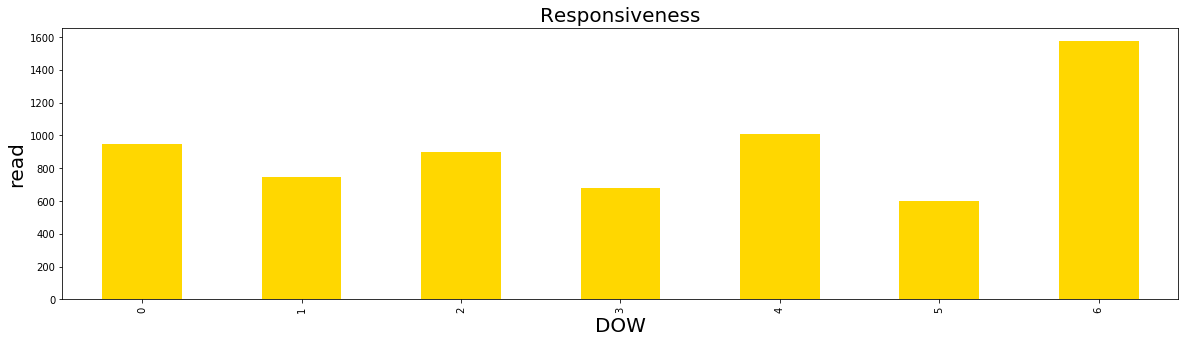

In [26]:
plt.title('Responsiveness', fontsize=20)
fromchat2017.groupby(by='DOW').count()['readBy'].plot(figsize=(20,5), kind='bar', color='gold')
plt.xlabel('DOW', fontsize=20)
plt.ylabel('read', fontsize=20)